#  Stable Voting in Julia

Implementation of (Simple) Stable Voting and other voting methods mentioned in the paper in Julia. 


In [20]:
import Base: length
using BenchmarkTools
using Random
using PrettyTables
using GraphPlot
using LightGraphs
using LightGraphs: smallgraph
using SimpleWeightedGraphs
using IterTools
using Distributed
using Statistics
using DataFrames
using Combinatorics
using CSV
using StatsPlots
import Cairo, Fontconfig
using Gadfly

@ptconf tf = tf_borderless noheader = true crop = :horizontal 


## Ballots and Profiles

In [21]:
# An anonymous ballot -- a ranking together with its weight
#
# The assumption is that a ranking of n candidates is a linear order of the numbers 1...n, 
#
mutable struct Ballot     
    ranking::Array{Int64, 1} # array representing the ranking of the candidates
    weight::Int64 # the number of voters that submitted this ballot
    ranks::Array{Int64,1} # ranks[n] is the rank of candidate n
end

# functions to create a ballot

ballot(cs::Int64...; weight::Int64=1) = Ballot(collect(cs), weight, [findfirst(cand -> cand == c, collect(cs)) for c in 1:length(collect(cs))])
ballot(r::Vector{Int64}; weight::Int64=1) = Ballot(r, weight, [findfirst(cand -> cand == c, r) for c in 1:length(r)])

getrank(b::Ballot, c) = b.ranks[c] # return the rank of candidate c
prefers(b::Ballot, c1, c2) = getrank(b, c1) < getrank(b, c2) # true if c1 is ranked above c2

length(b::Ballot) = length(b.ranking)
candidates(b::Ballot) = collect(1:length(b))  # the candidates in the ballot

rankedlast(b::Ballot, c) = b.ranks[c] == length(b.ranking) # true if c is ranked last in the ballot
rankedfirst(b::Ballot, c) = getrank(b, c) == 1 # true if c is ranked first in the ballot


# Remove candidate a from ballot b
function remcand(b::Ballot, a)
     new_ranking = map(c ->  c < a ? c : c-1, b.ranking[b.ranking .!= a])
     Ballot(new_ranking, b.weight, [findfirst(cand -> cand == c, new_ranking) for c in 1:length(new_ranking)])
end

function remcand!(b::Ballot, a)
    new_ranking = map(c ->  c < a ? c : c-1, b.ranking[b.ranking .!= a])
    b.ranking = new_ranking
    b.ranks = [findfirst(cand -> cand == c, new_ranking) for c in 1:length(new_ranking)]
end




remcand! (generic function with 1 method)

In [22]:
# An example to illustrated some of the functions
b = ballot(2, 1, 4, 3)
println(b, "\n")

println("2 is preferred to 1 is ", prefers(b, 2, 1))
println("3 is preferred to 4 is ", prefers(b, 3, 4))
println("2 is ranked first is ", rankedfirst(b, 2))
println("1 is ranked first is ", rankedfirst(b, 1))
println("3 is ranked last is ", rankedfirst(b, 3))
println("4 is ranked last is ", rankedfirst(b, 4))

println("\nRemoved candidate 2 from the ballot:")
remcand!(b, 2)
println(b)
println("Note that candidates have been renamed.")


Ballot([2, 1, 4, 3], 1, [2, 1, 4, 3])

2 is preferred to 1 is true
3 is preferred to 4 is false
2 is ranked first is true
1 is ranked first is false
3 is ranked last is false
4 is ranked last is false

Removed candidate 2 from the ballot:
Ballot([1, 3, 2], 1, [1, 3, 2])
Note that candidates have been renamed.


In [23]:

# A profile is an array of anonymous ballots, a list of candidates and 
# a cmap assocaiting candidate numbers with their names
mutable struct Profile
    ballots::Array{Ballot, 1}
    numcands::Int64
    candidates::Array{Int64, 1}
    cmap::Dict{Int64, Int64}
end

# function to create a profile from a list of ballots

profile(ballots::Array{Ballot, 1}) = length(ballots) > 0 ? Profile(ballots, length(ballots[1].ranking), sort(ballots[1].ranking), Dict(c => c for c in ballots[1].ranking)) : Profile([], 0, [], Dict())

# helper functions for profiles

numvoters(prof::Profile) = sum([v.weight for v in prof.ballots])
numcandidates(prof::Profile) = length(prof.candidates)
support(prof::Profile, a, b) = (S = prefers(prof.ballots[1],a,b) ? prof.ballots[1].weight : 0; for P in prof.ballots[2:end]; S += prefers(P,a,b) ? P.weight : 0; end; S)
margin(prof::Profile, a, b) = support(prof, a, b) - support(prof, b, a)
maj_preferred(prof::Profile, a, b) = margin(prof, a, b) > 0
tied(prof::Profile, a, b) = margin(prof, a, b) == 0
is_weak_cw(prof::Profile, a) = all([!maj_preferred(prof, b, a) for b in prof.candidates])
has_condorcet_winner(prof::Profile) = any([all([maj_preferred(prof, c, a) for a in prof.candidates if a != c]) for c in prof.candidates])

candidx(prof::Profile, a) = [idx for (idx,c) in prof.cmap if c == a][1]

dom(prof::Profile, a) = Set([prof.cmap[c] for c in prof.candidates if margin(prof, candidx(prof, a), c) > 0])
dominators(prof::Profile, a) = Set([prof.cmap[c] for c in prof.candidates if margin(prof, c, candidx(prof, a)) > 0])

numcands(prof::Profile) = length(prof.candidates)
allcands(prof::Profile) = [prof.cmap[cidx] for cidx in prof.candidates]

numrank(prof::Profile, c, pos) = (S = getrank(prof.ballots[1], c) == pos ? prof.ballots[1].weight : 0; for P in prof.ballots[2:end]; S += getrank(P,c) == pos ? P.weight : 0; end; S)

function numrank_first(prof::Profile, c) 
    firsts = [b.ranking[1] for b in prof.ballots]
    is_cand = firsts .== c
    ns = is_cand .* [b.weight for b in prof.ballots]
    return sum(ns)
end

candset(prof::Profile, cs) = Set([prof.cmap[c] for c in cs])

function condorcet_winner(prof::Profile)
    for c in prof.candidates
        if all([maj_preferred(prof, c, a) for a in prof.candidates if a != c])
            return candset(prof, [c])
        end
    end
    return candset(prof, [])
end


function display_prof(prof::Profile; distinguished_cands = [])
    hs = []
    if length(distinguished_cands) == 1
        h1_c = HTMLHighlighter((data, i, j) ->  data[i, j] == prof.cmap[distinguished_cands[1]], HTMLDecoration(color = "blue", font_weight = "bold"));
        hs = [h1_c]
    elseif length(distinguished_cands) == 2
        h1_c = HTMLHighlighter((data, i, j) ->  data[i, j] == prof.cmap[distinguished_cands[1]], HTMLDecoration(color = "blue", font_weight = "bold"));
        h2_c = HTMLHighlighter((data, i, j) ->  data[i, j] == prof.cmap[distinguished_cands[2]], HTMLDecoration(color = "red", font_weight = "bold"));
        hs=[h1_c, h2_c]
    end
    data = [prof.cmap[b.ranking[1]] for b in prof.ballots]'
    for r in 2:numcandidates(prof)
        data = vcat(data,[prof.cmap[b.ranking[r]] for b in prof.ballots]')
    end
    header = [b.weight for b in prof.ballots]
    pretty_table( tf = tf_html_minimalist, data; header = header, alignment=:c, highlighters =Tuple(hs) )    
end


function margin_matrix(prof::Profile)
    
    candidates = prof.candidates
    mmatrix = zeros(length(candidates), length(candidates))
    for c1 in candidates
        for c2 in candidates
            mmatrix[c1, c2] = margin(prof, c1, c2)
            
        end
    end
    return mmatrix
end

function remove_candidate(prof::Profile, cand_to_remove)
    
    new_ballots = remcand.(prof.ballots, cand_to_remove)
    new_cands = 1:length(new_ballots[1])
    cmap = Dict(c => c < cand_to_remove ? prof.cmap[c] : prof.cmap[c + 1] for c in new_cands)
    return Profile(new_ballots, length(new_cands), new_cands, cmap)
end  

function remove_candidates(prof::Profile, cands_to_remove)
    new_ballots = prof.ballots
    new_cmap = prof.cmap
    new_cands = prof.candidates
    #println(cands_to_remove)
    for a in cands_to_remove
        #println(a)
        cand_to_remove = [k for (k,c) in new_cmap if c == a][1]
        new_ballots = remcand.(new_ballots, cand_to_remove)
        new_cands = 1:length(new_ballots[1])
        #println(new_cands)
        new_cmap = Dict(c => c < cand_to_remove ? new_cmap[c] : new_cmap[c + 1] for c in new_cands)
    end
    #println(new_ballots)
    return Profile(new_ballots, length(new_cands), new_cands, new_cmap)
end  

function margin_graph(prof::Profile)
    mg = SimpleWeightedDiGraph(numcandidates(prof))
    for c1 in prof.candidates
        for c2 in prof.candidates
            if maj_preferred(prof, c1, c2)
                add_edge!(mg, c1, c2, margin(prof, c1, c2))
            end
        end
    end
    return mg
end

function display_mg(prof::Profile)
    mg = margin_graph(prof)
    display(gplot(mg, 
            layout = circular_layout,
            nodelabel=[prof.cmap[c] for c in prof.candidates], 
            edgelabel = [e.weight for e in edges(mg)], 
            edgelabeldistx=0.0, edgelabeldisty=0.0))
end



display_mg (generic function with 1 method)

In [24]:

prof = profile([
        ballot(1, 2, 3), 
        ballot(2, 3, 1), 
        ballot(3, 1, 2)
        ])

display_prof(prof)

println("The margin of 1 over 3 is ", margin(prof, 1, 3))
println("The margin of 3 over 1 is ", margin(prof, 3, 1))
print("Condorcet winner: ", condorcet_winner(prof))

1,1,1
1,2,3
2,3,1
3,1,2


The margin of 1 over 3 is -1
The margin of 3 over 1 is 1
Condorcet winner: Set{Int64}()

## Generate Profiles

In [25]:
# The URN model for generating profiles of linear orders
# See https://pref-voting.readthedocs.io/en/latest/generate_profiles.html#pref_voting.generate_profiles.generate_profile for a discussion. 

function gen_urn(num_cands, num_voters, replace)
    
    vote_map = Dict{Vector{Int64}, Int64}()
    replace_votes = Dict{Vector{Int64}, Int64}()
    ic_size = factorial(big(num_cands))
    replace_size = 0
    for v in 1:num_voters
        flip = rand(1:(ic_size+replace_size))    
        if flip <= ic_size
            new_ranking = randperm(num_cands)
            vote_map[new_ranking] = get(vote_map, new_ranking, 0) + 1
            replace_votes[new_ranking] = get(replace_votes, new_ranking, 0) + replace
            replace_size += replace   
        else
            flip = flip - ic_size
            for r in keys(replace_votes)
                flip = flip - replace_votes[r]
                if flip <= 0
                    vote_map[r] = get(vote_map, r, 0) + 1
                    replace_votes[r] = get(replace_votes, r, 0) + replace
                    replace_size += replace
                    break
                end
            end 
        end    
    end
    return vote_map
end

function generate_profile(num_cands, num_voters; probmod = "IC")
    probmodels = Dict(
        "IC" => Dict("func" => gen_urn, "param" => 0), 
        "IAC" => Dict("func" => gen_urn, "param" => 1), 
        "URN" => Dict("func" => gen_urn, "param" => 10), 
    )
    
    vote_map = probmodels[probmod]["func"](num_cands, num_voters, probmodels[probmod]["param"])
    
    return profile([ballot(v; weight=w) for (v,w) in vote_map])
end



generate_profile (generic function with 1 method)

## Voting Methods

In [26]:
function simple_stable_voting_(prof::Profile; curr_cands = Set{Int64}([]), mem_sv_winners = Dict())
    
    curr_cands = curr_cands != Set([]) ? curr_cands : Set(prof.candidates)
    
    sv_winners = []
    
    matches = [(a,b) for a in curr_cands for b in curr_cands if a != b]
    
    margins = Set([margin(prof, ab[1], ab[2]) for ab in matches])

    if length(curr_cands) == 1
        mem_sv_winners[curr_cands] = curr_cands
        return candset(prof, curr_cands), mem_sv_winners
    end
    sorted_margins = sort!(collect(margins), rev=true)
    
    for m in sorted_margins
        for (a,b) in [ab_match for ab_match in matches if margin(prof, ab_match[1], ab_match[2]) == m]
            if a ∉ sv_winners
                cands_minus_b = Set([c for c in curr_cands if c != b])
                if !haskey(mem_sv_winners, cands_minus_b)
                    ws, mem_sv_winners = simple_stable_voting_(prof; curr_cands = cands_minus_b, mem_sv_winners = mem_sv_winners)
                    mem_sv_winners[cands_minus_b] = ws
                else 
                    ws = mem_sv_winners[cands_minus_b]
                end
                if a ∈ ws
                    push!(sv_winners, a)
                end
            end
        end
        if length(sv_winners) > 0
            return candset(prof, sv_winners), mem_sv_winners
        end
    end
end


function simple_stable_voting(prof::Profile)
    return simple_stable_voting_(prof; curr_cands = Set{Int64}([]), mem_sv_winners = Dict())[1]
end

function simple_stable_voting_faster(prof::Profile)
    
    cw = condorcet_winner(prof)
    
    if isempty(cw)
        return simple_stable_voting_(prof; curr_cands = Set{Int64}([]), mem_sv_winners = Dict())[1]
    else
        return cw
    end
end



simple_stable_voting_faster (generic function with 1 method)

In [27]:
function split_cycle_faster(prof::Profile; curr_cands = Set([]))
    # Implementation of Split Cycle based on the Floyd-Warshall algorithm: 
    # see https://pref-voting.readthedocs.io/en/latest/margin_based_methods.html#split-cycle-faster
    
    curr_cands = curr_cands != Set([]) ? collect(curr_cands) : collect(prof.candidates)
    s_matrix = fill(-Inf, (length(curr_cands), length(curr_cands)))
    weak_condorcet_winners = Dict(c => true for c in curr_cands)
    for (c1_idx, c1) in enumerate(curr_cands)
        for (c2_idx, c2) in enumerate(curr_cands)
            if c1 == c2 ||  margin(prof, c1, c2) > 0
                s_matrix[c1_idx, c2_idx] =  margin(prof, c1, c2)
                weak_condorcet_winners[c2] = weak_condorcet_winners[c2] && (c1 == c2) # Weak Condorcet winners are Split Cycle winners

            end            
        end
    end

    strength = deepcopy(s_matrix)
    for (i_idx, i) in enumerate(curr_cands)
        for (j_idx, j) in enumerate(curr_cands)
            if i != j
                #if !weak_condorcet_winners[j]
                for (k_idx, k) in enumerate(curr_cands)
                    if i != k && j != k
                        strength[j_idx,k_idx] = maximum([strength[j_idx, k_idx], minimum([strength[j_idx, i_idx], strength[i_idx, k_idx]])])
                    end
                end
                #end
            end
        end
    end
    winners = Dict(c => true for c in curr_cands)
   
    for (i_idx, i) in enumerate(curr_cands)
        for (j_idx, j) in enumerate(curr_cands)
            if i != j
                if s_matrix[j_idx, i_idx] > strength[i_idx, j_idx]
                    winners[i] = false
                end
            end
        end
    end
    return candset(prof, [c for c in curr_cands if winners[c]])
end


split_cycle_faster (generic function with 1 method)

In [28]:
function stable_voting_(prof::Profile; curr_cands = Set{Int64}([]), mem_sv_winners = Dict())
    curr_cands = curr_cands != Set([]) ? curr_cands : Set(prof.candidates)
    
    sv_winners = []
    undefeated_candidates = split_cycle_faster(prof;  curr_cands = curr_cands)
    matches = [(a,b) for a in curr_cands for b in curr_cands if a != b && a ∈ undefeated_candidates]
    margins = Set([margin(prof, ab[1], ab[2]) for ab in matches])

    if length(curr_cands) == 1
        mem_sv_winners[curr_cands] = curr_cands
        return candset(prof, curr_cands), mem_sv_winners
    end
    sorted_margins = sort!(collect(margins), rev=true)
    
    for m in sorted_margins
        for (a,b) in [ab_match for ab_match in matches if margin(prof, ab_match[1], ab_match[2]) == m]
            if a ∉ sv_winners
                cands_minus_b = Set([c for c in curr_cands if c != b])
                if !haskey(mem_sv_winners, cands_minus_b)
                    ws, mem_sv_winners = stable_voting_(prof; curr_cands = cands_minus_b, mem_sv_winners = mem_sv_winners)
                    mem_sv_winners[cands_minus_b] = ws
                else 
                    ws = mem_sv_winners[cands_minus_b]
                end
                if a ∈ ws
                    push!(sv_winners, a)
                end
            end
        end
        if length(sv_winners) > 0
            return candset(prof, sv_winners), mem_sv_winners
        end
    end
end

function stable_voting(prof::Profile)
    return stable_voting_(prof; curr_cands = Set{Int64}([]), mem_sv_winners = Dict())[1]
end

function stable_voting_faster(prof::Profile)
    
    cw = condorcet_winner(prof)
    
    if isempty(cw)
        return stable_voting_(prof; curr_cands = Set{Int64}([]), mem_sv_winners = Dict())[1]
    else
        return cw
    end
end


stable_voting_faster (generic function with 1 method)

In [29]:

function plurality(prof::Profile)
    max_pl_score = -1
    winners = Vector()
    for c in prof.candidates
        pl_score = numrank(prof, c, 1)::Int64
        if pl_score > max_pl_score
            winners = [c]
            max_pl_score = pl_score
        elseif pl_score == max_pl_score
            append!(winners, c)
        end
    end
    return candset(prof, winners)
end



plurality (generic function with 1 method)

In [30]:

function instant_runoff(prof::Profile)
    
    numcands = length(prof.candidates)
    numvs =  numvoters(prof) 
    strict_maj_size = rem(numvs, 2) == 0 ? Int(round(numvs / 2) + 1) : Int(ceil(round(numvs) / 2))
    winners = [c for c in prof.candidates if numrank(prof,c, 1) >= strict_maj_size]
    reduced_prof = prof
    while length(winners) == 0
        
        pl_scores = Dict(c => numrank(reduced_prof, c, 1) for c in reduced_prof.candidates)
        min_first_place = minimum(values(pl_scores))        
        
        cands_to_rem = [reduced_prof.cmap[c] for c in reduced_prof.candidates if pl_scores[c] == min_first_place]
        if length(cands_to_rem) == length(reduced_prof.candidates)
            winners = reduced_prof.candidates
        else
            winners = [c for c in reduced_prof.candidates if numrank(reduced_prof,c, 1) >= strict_maj_size]
        end
        if isempty(winners)
            reduced_prof = remove_candidates(reduced_prof, cands_to_rem)
        end
    end
    return candset(reduced_prof, winners)
end


function smith_instant_runoff(prof::Profile)
    
    s_set = smith_set(prof)
    reduced_prof = remove_candidates(prof, [c for c in allcands(prof) if c ∉ s_set])
    return instant_runoff(reduced_prof)
end


function instant_runoff_put(prof::Profile)
    
    numcands = length(prof.candidates)
    
    if  length(prof.candidates) == 1
        return candset(prof,prof.candidates)
    end
    numvs = numvoters(prof) 
    pl_scores = Dict(c => numrank(prof, c, 1) for c in prof.candidates)
    min_first_place = minimum(values(pl_scores))        
    cands_to_rem = [prof.cmap[c] for c in prof.candidates if pl_scores[c] == min_first_place]
    winners = Int[]
    for cand_to_rem in cands_to_rem
        reduced_prof = remove_candidates(prof, [cand_to_rem])
        append!(winners, instant_runoff_put(reduced_prof))
    end
    
    return Set(winners)
end


function smith_instant_runoff_put(prof::Profile)
    s_set = smith_set(prof)
    reduced_prof = remove_candidates(prof, [c for c in allcands(prof) if c ∉ s_set])
    return instant_runoff_put(reduced_prof)
end


smith_instant_runoff_put (generic function with 1 method)

In [31]:
function minimax(prof::Profile)   
    mmatrix = margin_matrix(prof)
    max_losses = Dict( c => maximum(mmatrix[:, c]) for c in prof.candidates)
    min_max_loss = minimum(values(max_losses))
    return candset(prof, [c for c in prof.candidates if max_losses[c] == min_max_loss])
end


minimax (generic function with 1 method)

In [32]:

function weak_margin_graph(prof::Profile)
    mg = SimpleDiGraph(numcandidates(prof))
    for c1 in prof.candidates
        for c2 in prof.candidates
            if maj_preferred(prof, c1, c2) 
                add_edge!(mg, c1, c2, margin(prof, c1, c2))
            end
            if c1 != c2 && tied(prof, c1, c2)
                add_edge!(mg, c1, c2, zero) # use 0.01 for a 0 weight
            end
        end
    end
    return mg
end

function smith_set(prof::Profile)
    wmg = weak_margin_graph(prof)
    sscs = strongly_connected_components(wmg)
    min_indegree = minimum([maximum([indegree(wmg, n) for n in comp]) for comp in sscs])
    s_set = [comp for comp in sscs if maximum([indegree(wmg,n) for n in comp]) == min_indegree][1]
    return candset(prof, s_set)
end


smith_set (generic function with 1 method)

In [33]:

function beat_path(prof::Profile)
    # Implementation of Beat Path based on the Floyd-Warshall algorithm: 
    # see https://pref-voting.readthedocs.io/en/latest/margin_based_methods.html#beat-path-faster
    
    candidates = prof.candidates
    strength = fill(-Inf, (length(candidates), length(candidates)))
    for c1 in candidates
        for c2 in candidates
            if c1 == c2 ||  margin(prof, c1, c2) > 0
                strength[c1, c2] =  margin(prof, c1, c2)
            end            
        end
    end
    for i in candidates
        for j in candidates
            if i != j
                for k in candidates
                    if i != k && j != k
                        strength[j,k] = maximum([strength[j, k], minimum([strength[j, i], strength[i,k]])])
                    end
                end
            end
        end
    end
    winners = Dict(c => true for c in candidates)
    for i in candidates
        for j in candidates
            if i != j
                if strength[j, i] > strength[i, j]
                    winners[i] = false
                end
            end
        end
    end
    return candset(prof, [c for c in candidates if winners[c]])
end


beat_path (generic function with 1 method)

## Irresoluteness Data

In [ ]:
@time begin 
    
    filename_irresoluteness1 = "multwinners_nvoters.csv"

    all_num_cands = [
    #    3,
    #    4,
    #    5,
        6,
    #    7,
    #    8,
    ]
    all_num_voters = [
        (4, 5),
        (10, 11), 
        (20, 21), 
        (50, 51), 
        (100, 101), 
        (500, 501), 
        (1000, 1001), 
        (5000, 5001)
    ]

    num_trials = 50000  

    vmnames = Dict(
        plurality => "Plurality",
        beat_path => "Beat Path",
        instant_runoff_put => "Instant Runoff",
        stable_voting => "Stable Voting",
        #split_cycle => "Split Cycle",
        #minimax => "Minimax",
        #smith_set => "Top Cycle",
    )

    vms = keys(vmnames)

    data_for_df = Dict(
        "num_cands" => [], 
        "num_voters" => [], 
        "vm" => [], 
        "num_profiles" => [],
        "perc_mult_winners" => [],
        "avg_ws_size" => []
    )

    for num_cands in all_num_cands
        println(num_cands)
        for num_voters in all_num_voters
            println("\t", num_voters)
            num_voters_even, num_voters_odd = num_voters

            mult_winners = Dict(vmnames[vm] => 0 for vm in vms)
            ws_sizes = Dict(vmnames[vm] => [] for vm in vms)

            # even number of voters

            @inbounds for t in 1:num_trials
                prof = generate_profile(num_cands, num_voters_even)

                @inbounds for vm in vms
                    ws = vm(prof)
                    mult_winners[vmnames[vm]] += length(ws) > 1 ? 1 : 0
                    append!(ws_sizes[vmnames[vm]], length(ws))
                end
            end

            # odd number of voters

            @inbounds for t in 1:num_trials
                prof = generate_profile(num_cands, num_voters_odd)

                @inbounds for vm in vms
                    ws = vm(prof)
                    mult_winners[vmnames[vm]] += length(ws) > 1 ? 1 : 0
                    append!(ws_sizes[vmnames[vm]], length(ws))
                end
            end

            num_profiles = 2 * num_trials

            @inbounds for vm in vms
                push!(data_for_df["num_cands"], num_cands)
                push!(data_for_df["num_voters"], num_voters)
                push!(data_for_df["vm"], vmnames[vm])
                push!(data_for_df["num_profiles"], num_profiles)
                push!(data_for_df["perc_mult_winners"], mult_winners[vmnames[vm]] / num_profiles)
                push!(data_for_df["avg_ws_size"], mean(ws_sizes[vmnames[vm]]))

            end
            df_irresoluteness_nvoters = DataFrame(data_for_df)
            CSV.write("./" * filename_irresoluteness1, df_irresoluteness_nvoters)

        end
    end
    println("Done.")
end

In [34]:
# load the pre-computed data, comment to display the data generated in the previous cell. 
filename_irresoluteness1 = "data/multwinners_nvoters.csv"

df_irresoluteness_nvoters = DataFrame(CSV.File(filename_irresoluteness1))

df_irresoluteness_nvoters[!,:num_voters] = string.(df_irresoluteness_nvoters[:,:num_voters])

df_irresoluteness_nvoters

,avg_ws_size,num_cands,num_profiles,num_voters,perc_mult_winners,vm
,Float64,Int64,Int64,String,Float64,String
1,1.08062,6,100000,"(4, 5)",0.07166,Stable Voting
2,1.75372,6,100000,"(4, 5)",0.33489,Plurality
3,1.89299,6,100000,"(4, 5)",0.54652,Instant Runoff
4,1.71112,6,100000,"(4, 5)",0.43541,Beat Path
5,1.03186,6,100000,"(10, 11)",0.02967,Stable Voting
6,1.45463,6,100000,"(10, 11)",0.31747,Plurality
7,1.60905,6,100000,"(10, 11)",0.41204,Instant Runoff
8,1.43824,6,100000,"(10, 11)",0.31459,Beat Path
9,1.0154,6,100000,"(20, 21)",0.0147,Stable Voting


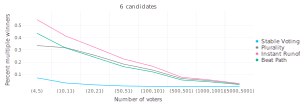

In [35]:
ylabel = "Percent multiple winners"
xlabel = "Number of voters"
set_default_plot_size(30cm, 11cm)

df = df_irresoluteness_nvoters
p_irresoluteness_nvoters = Gadfly.plot(
    layer(df[(df.num_cands .== 6) .& (df.vm .== "Stable Voting"), :], 
        x="num_voters", 
        y="perc_mult_winners",
        Theme(default_color=colorant"deepskyblue", 
            line_width=1.5pt),
        Geom.line, order=1),
    layer(df[(df.num_cands .== 6) .& (df.vm .== "Plurality"), :], 
        x="num_voters", 
        y="perc_mult_winners",
        Theme(default_color=colorant"gray", 
            line_width=1.5pt),
        Geom.line, order=2),
    layer(df[(df.num_cands .== 6) .& (df.vm .== "Instant Runoff"), :], 
        x="num_voters", 
        y="perc_mult_winners",
    Theme(default_color=colorant"#FF6DAE", line_width=1.5pt),
    Geom.line, order=3),
    layer(df[(df.num_cands .== 6) .& (df.vm .== "Beat Path"), :], 
        x="num_voters", 
        y="perc_mult_winners",
        Theme(default_color=colorant"#00B78D", 
            line_width=1.5pt),
        Geom.line, order=4),
    Guide.title("6 candidates"), 
    Coord.cartesian(ymax = 0.6), 
    Theme(key_label_font_size=16pt, 
        key_title_font_size = 16pt, 
        major_label_font_size = 16pt, 
        minor_label_font_size = 13pt, 
        colorkey_swatch_shape=:square, 
        point_size=4pt),
    Guide.manual_color_key("", 
        ["Stable Voting",  "Plurality", "Instant Runoff", "Beat Path"], 
        ["deepskyblue", "gray", "#FF6DAE", "#00B78D"]),
    Guide.ylabel(ylabel, :vertical), 
    Guide.xlabel(xlabel))

display(p_irresoluteness_nvoters)
draw(PDF("irresoluteness_diff_nvoters.pdf", 30cm, 11cm), p_irresoluteness_nvoters)



In [ ]:
@time begin 
    
    filename_irresoluteness2 = "multwinners_ncandidates.csv"

    all_num_cands = [
        3,
        4,
        5,
        6,
        7,
        8,
        9
    ]
    all_num_voters = [
#         (4, 5),
#         (10, 11), 
#         (20, 21), 
#         (50, 51), 
        (100, 101), 
#         (500, 501), 
#         (1000, 1001), 
#         (5000, 5001)
    ]

    num_trials = 50000  

    vmnames = Dict(
        plurality => "Plurality",
        beat_path => "Beat Path",
        instant_runoff_put => "Instant Runoff",
        stable_voting => "Stable Voting",
        #split_cycle => "Split Cycle",
        #minimax => "Minimax",
        #smith_set => "Top Cycle",
    )

    vms = keys(vmnames)

    data_for_df = Dict(
        "num_cands" => [], 
        "num_voters" => [], 
        "vm" => [], 
        "num_profiles" => [],
        "perc_mult_winners" => [],
        "avg_ws_size" => []
    )

    for num_cands in all_num_cands
        println(num_cands)
        for num_voters in all_num_voters
            println("\t", num_voters)
            num_voters_even, num_voters_odd = num_voters

            mult_winners = Dict(vmnames[vm] => 0 for vm in vms)
            ws_sizes = Dict(vmnames[vm] => [] for vm in vms)

            # even number of voters

            @inbounds for t in 1:num_trials
                prof = generate_profile(num_cands, num_voters_even)

                @inbounds for vm in vms
                    ws = vm(prof)
                    mult_winners[vmnames[vm]] += length(ws) > 1 ? 1 : 0
                    append!(ws_sizes[vmnames[vm]], length(ws))
                end
            end

            # odd number of voters

            @inbounds for t in 1:num_trials
                prof = generate_profile(num_cands, num_voters_odd)

                @inbounds for vm in vms
                    ws = vm(prof)
                    mult_winners[vmnames[vm]] += length(ws) > 1 ? 1 : 0
                    append!(ws_sizes[vmnames[vm]], length(ws))
                end
            end

            num_profiles = 2 * num_trials

            @inbounds for vm in vms
                push!(data_for_df["num_cands"], num_cands)
                push!(data_for_df["num_voters"], num_voters)
                push!(data_for_df["vm"], vmnames[vm])
                push!(data_for_df["num_profiles"], num_profiles)
                push!(data_for_df["perc_mult_winners"], mult_winners[vmnames[vm]] / num_profiles)
                push!(data_for_df["avg_ws_size"], mean(ws_sizes[vmnames[vm]]))

            end

            df = DataFrame(data_for_df)
            CSV.write("./" * filename_irresoluteness1, df)
        end
    end

    println("Done.")
end

In [36]:
# load the pre-computed data, comment to display the data generated in the previous cell. 
filename_irresoluteness2 = "./data/multwinners_ncandidates.csv"

df_irresoluteness_ncands = DataFrame(CSV.File(filename_irresoluteness2))

df_irresoluteness_ncands[!,:num_voters] = string.(df_irresoluteness_ncands[:,:num_voters])
df_irresoluteness_ncands[!,:num_cands] = string.(df_irresoluteness_ncands[:,:num_cands])

df_irresoluteness_ncands

,avg_ws_size,num_cands,num_profiles,num_voters,perc_mult_winners,vm
,Float64,String,Int64,String,Float64,String
1,1.03021,3,100000,"(100, 101)",0.02756,Stable Voting
2,1.07112,3,100000,"(100, 101)",0.07112,Plurality
3,1.07476,3,100000,"(100, 101)",0.07296,Instant Runoff
4,1.06958,3,100000,"(100, 101)",0.06693,Beat Path
5,1.01125,4,100000,"(100, 101)",0.0107,Stable Voting
6,1.10206,4,100000,"(100, 101)",0.09541,Plurality
7,1.10981,4,100000,"(100, 101)",0.10317,Instant Runoff
8,1.09308,4,100000,"(100, 101)",0.08697,Beat Path
9,1.0055,5,100000,"(100, 101)",0.00536,Stable Voting


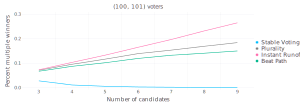

In [37]:
set_default_plot_size(30cm, 11cm)

df = df_irresoluteness_ncands
p_irresoluteness_ncands = Gadfly.plot( 
    layer(df[(df.num_voters .== "(100, 101)") .& (df.vm .== "Stable Voting"), :], 
        x="num_cands", 
        y="perc_mult_winners",
        Theme(default_color=colorant"deepskyblue", 
            line_width=1.5pt, 
            colorkey_swatch_shape=:square, 
            point_size=100pt),
        Geom.line, order=1),
    layer(df[(df.num_voters .== "(100, 101)") .& (df.vm .== "Plurality"), :], 
        x="num_cands", 
        y="perc_mult_winners",
        Theme(default_color=colorant"gray", 
            line_width=1.5pt, 
            colorkey_swatch_shape=:square),
        Geom.line, order=2),
    layer(df[(df.num_voters .== "(100, 101)") .& (df.vm .== "Instant Runoff"), :], 
        x="num_cands", 
        y="perc_mult_winners",
        Theme(default_color=colorant"#FF6DAE", 
            line_width=1.5pt, 
            colorkey_swatch_shape=:square),
        Geom.line, order=3),    
    layer(df[(df.num_voters .== "(100, 101)") .& (df.vm .== "Beat Path"), :], 
        x="num_cands", 
        y="perc_mult_winners",
        Theme(default_color=colorant"#00B78D", 
            line_width=1.5pt, 
            colorkey_swatch_shape=:square),
        Geom.line, order=4),  
    Guide.title("(100, 101) voters"),  
    Theme(key_label_font_size=16pt,
        key_title_font_size = 16pt, 
        major_label_font_size = 16pt, 
        minor_label_font_size = 13pt, 
        colorkey_swatch_shape=:square, 
        point_size=4pt),
    Guide.manual_color_key("", 
        ["Stable Voting",  "Plurality", "Instant Runoff", "Beat Path"], 
        ["deepskyblue", "gray", "#FF6DAE", "#00B78D"]),
    Guide.ylabel(ylabel, :vertical), 
    Guide.xlabel("Number of candidates"))

display(p_irresoluteness_ncands)
draw(PDF("irresoluteness_diff_ncands.pdf", 30cm, 11cm), p_irresoluteness_ncands)



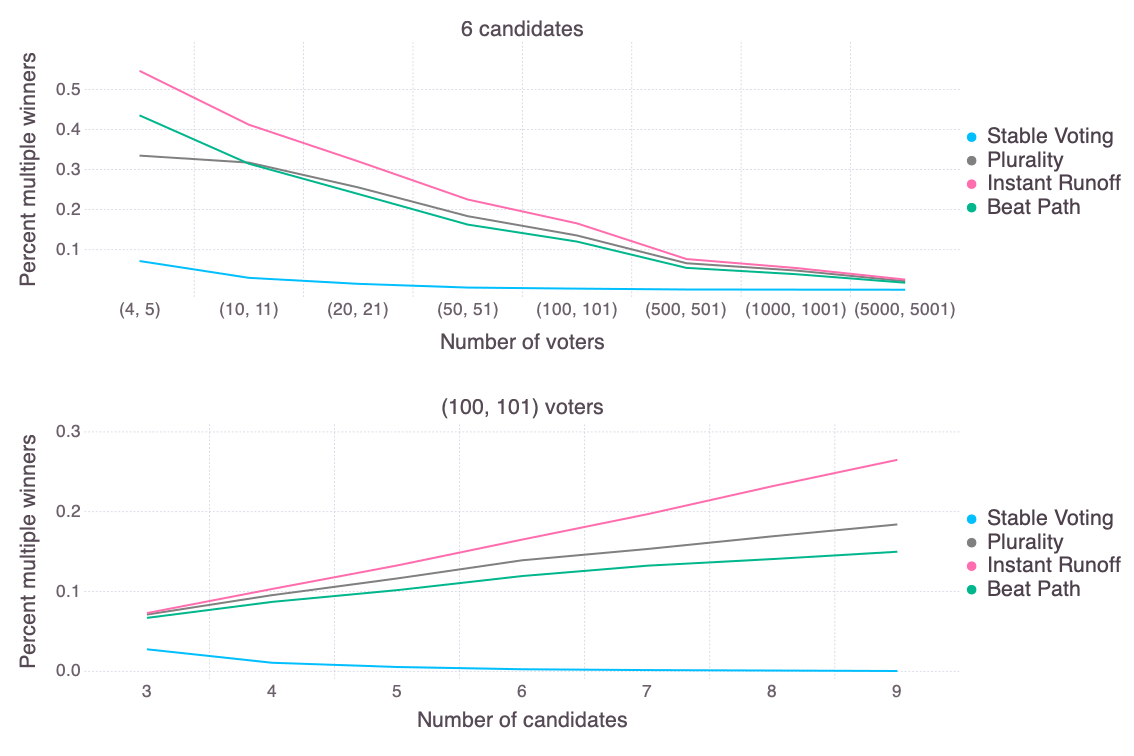

In [38]:
# Combined graphs

set_default_plot_size(30cm, 20cm)

p = vstack(p_irresoluteness_nvoters, p_irresoluteness_ncands)
display(p)
draw(PDF("irresoluteness.pdf", 30cm, 22cm), p)


## Monotonicity Violations

In [ ]:

function drop(b::Ballot, c, num_to_drop) 
    new_ranking = deepcopy(b.ranking)
    idx = getrank(b,c)
    new_idx = idx + num_to_drop
    try 
        deleteat!(new_ranking, idx)
        insert!(new_ranking, new_idx, c)
    catch e
        if isa(e, BoundsError)
            error("ERROR: Trying to drop a candidate that is ranked in position $(idx)")
        else
            prinln(e)
        end
    end
    return ballot(new_ranking; weight = b.weight)
end

function lift(b::Ballot, c, num_to_lift) 
    new_ranking = deepcopy(b.ranking)
    idx = getrank(b,c)
    new_idx = idx - num_to_lift
    try 
        deleteat!(new_ranking, idx)
        insert!(new_ranking, new_idx, c)
    catch e
        if isa(e, BoundsError)
            error("ERROR: Trying to drop a candidate that is ranked in position $(idx)")
        else
            prinln(e)
        end
    end
    return ballot(new_ranking; weight = b.weight)
end

function has_monotonicity_failure(prof::Profile, vm)

    # returns true if either 
    # 1. there is a candidate c that is a winner in prof according to vm
    #    and a voter i such that after i moves c one position up in her ranking, candidate c becomes a loser.
    # or 
    # 2. there is a candidate c that is not a winner in prof according to vm
    #    and a voter i such that after i moves c one position down in her ranking, candidate c becomes a winner.
    #
    
    ws = vm(prof)
    
    winners = setdiff(Set(allcands(prof)), ws)
    losers = setdiff(Set(allcands(prof)), ws)
    
    for w in ws
        for b in prof.ballots
            if !rankedfirst(b, w)
                
                idx = getrank(b, w)
                
                if b.weight > 1
                    for offset in 1:idx - 1
                        new_ballots = [b2 for b2 in prof.ballots if b2 != b]
                        new_b0 = deepcopy(b)
                        new_b = lift(b, w, offset)
                        new_b.weight = 1
                        new_b0.weight = b.weight - 1
                        push!(new_ballots, new_b0)
                        push!(new_ballots, new_b)
                        new_prof = profile(new_ballots)
                        new_ws = vm(new_prof)
                        if w ∉ new_ws
                            return true
                        end
                    end
                elseif b.weight == 1
                    for offset in 1:idx - 1
                        new_ballots = [b2 for b2 in prof.ballots if b2 != b]
                        new_b = lift(b, w, offset)
                        new_b.weight = 1
                        push!(new_ballots, new_b)
                        new_prof = profile(new_ballots)
                        new_ws = vm(new_prof)
                        if w ∉ new_ws
                            return true
                        end
                    end
                end
            end
        end
    end
    if !isempty(losers)
        for l in losers
            for b in prof.ballots
                if !rankedlast(b, l)
                    idx = getrank(b, l)
                    
                    if b.weight > 1    
                        for offset in 1:length(b.ranking) - idx
                            new_ballots = [b2 for b2 in prof.ballots if b2 != b]
                            new_b0 = deepcopy(b)
                            new_b = drop(b, l, offset)
                            new_b.weight = 1
                            new_b0.weight = b.weight - 1
                            push!(new_ballots, new_b0)
                            push!(new_ballots, new_b)
                            new_prof = profile(new_ballots)
                            new_ws = vm(new_prof)
                            if l ∈ new_ws
                                return true
                            end
                        end
                    elseif b.weight == 1                        
                        for offset in 1:length(b.ranking) - idx
                            new_ballots = [b2 for b2 in prof.ballots if b2 != b]
                            new_b = drop(b, l, offset)
                            new_b.weight = 1
                            push!(new_ballots, new_b)
                            new_prof = profile(new_ballots)
                            new_ws = vm(new_prof)
                            if l ∈ new_ws
                                return true
                            end
                        end
                    end
                end
            end
        end
        return false
    end
    return false
end


In [ ]:
# Find the percentage of monotonicity violations for Instant Runoff PUT, Smith IRV PUT, and Stable Voting

@time begin
    
    mon_violation_func = has_monotonicity_failure
    filename = "./monotonicity_violations"
    
    all_num_cands = [
        6,
#         5, 
#         4,

    ]
    all_num_voters = [
        4, 
        5, 
        10, 
        11, 
        20, 
        21, 
        50, 
        51, 
#         100, 
#         101, 
#         500, 
#         501, 
#         5000, 
#         5001, 
    ]
    
    num_trials = 50000 # warning this will take about 3-4 hours to run. 

    vmnames = Dict(
        instant_runoff_put => "Instant Runoff",
        smith_instant_runoff_put => "Smith IRV",
        stable_voting => "Stable Voting",
    )

    vms = keys(vmnames)

    data_for_df = Dict(
        "num_cands" => [], 
        "num_voters" => [], 
        "vm" => [], 
        "perc_mon_violation" => [],
    )

    for num_cands in all_num_cands
        println(num_cands)
        for num_voters in all_num_voters
            println("\t", num_voters)

            num_violations = Dict(vmnames[vm] => 0 for vm in vms)
            ws_sizes = Dict(vmnames[vm] => [] for vm in vms)

            @inbounds for t in 1:num_trials
                prof = generate_profile(num_cands, num_voters)
                @inbounds for vm in vms
                    if mon_violation_func(prof, vm)
                        num_violations[vmnames[vm]] += 1
                    end
                end
            end

            @inbounds for vm in vms
                append!(data_for_df["num_cands"], num_cands)
                append!(data_for_df["num_voters"], num_voters)
                push!(data_for_df["vm"], vmnames[vm])
                append!(data_for_df["perc_mon_violation"], num_violations[vmnames[vm]] / num_trials)        
            end
            df = DataFrame(data_for_df)
            CSV.write(filename * ".csv", df)
        end
    end

    println("Done.")
    
end


In [47]:
# if skipped the simulation, set filename to the data you want to display
filename = "./data/monotonicity_violations"

df = DataFrame(CSV.File(filename * ".csv"))


,num_cands,num_voters,perc_mon_violation,vm
,Int64,Int64,Float64,String
1,6,4,0.01734,Smith IRV
2,6,4,0.0,Instant Runoff
3,6,4,0.0,Stable Voting
4,6,5,0.04972,Smith IRV
5,6,5,0.00804,Instant Runoff
6,6,5,0.00022,Stable Voting
7,6,10,0.05748,Smith IRV
8,6,10,0.05102,Instant Runoff
9,6,10,0.00224,Stable Voting


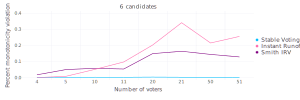

In [48]:
df = DataFrame(CSV.File(filename * ".csv"))

set_default_plot_size(30cm, 10cm)
df[!,:num_voters] = string.(df[:,:num_voters])

xlabel = "Number of voters"
ylabel = "Percent monotonicity violation"

p2 = Gadfly.plot( 
    layer(df[(df.num_cands .== 6) .& (df.vm .== "Stable Voting"), :],
        x="num_voters", 
        y="perc_mon_violation",
        Theme(default_color=colorant"deepskyblue",
            line_width=1.5pt),
        Geom.line, order=1),
    layer(df[(df.num_cands .== 6) .& (df.vm .== "Smith IRV"), :],
        x="num_voters", 
        y="perc_mon_violation",
        Theme(default_color=colorant"purple", 
            line_width=1.5pt),
        Geom.line, order=2),
    layer(df[(df.num_cands .== 6) .& (df.vm .== "Instant Runoff"), :],
        x="num_voters", 
        y="perc_mon_violation", 
        Theme(default_color=colorant"#FF6DAE", 
            line_width=1.5pt),
        Geom.line, order=3),
    Guide.title("6 candidates"),
    Guide.ylabel(ylabel, :vertical), 
    Guide.xlabel(xlabel),
    Theme(key_label_font_size=16pt, 
        key_title_font_size = 16pt, 
        major_label_font_size = 16pt, 
        minor_label_font_size = 13pt, 
        point_size=4pt),
    Guide.manual_color_key("", 
        ["Stable Voting",  "Instant Runoff", "Smith IRV"], 
        ["deepskyblue", "#FF6DAE", "purple"]))

display(p2)
draw(PDF(filename * ".pdf", 30cm, 10cm), p2)
